In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (accuracy_score, classification_report, 
                             confusion_matrix, roc_curve, roc_auc_score)

In [10]:

# -----------------------------
# 1. Load and Clean Data
# -----------------------------
df = pd.read_excel('Match Winner.xlsx')

# Drop unwanted columns
unwanted_cols = ['Unnamed: 0', 'Date', 'HomeTeam', 'AwayTeam', 'FTHG', 'FTAG', 'MW',
                 'HTFormPtsStr', 'ATFormPtsStr', 'HTFormPts', 'ATFormsPts',
                 'HTWinStreak3', 'HTWinStreak5', 'HTLossStreak3', 'HTLossStreak5',
                 'ATWinStreak3', 'ATWinStreak5', 'ATLossStreak3', 'ATLossStreak5']
df = df.drop(columns=unwanted_cols, errors='ignore')

# Drop duplicates
df = df.drop_duplicates()

# Save cleaned data
df.to_excel('cleaned_match_winner_data.xlsx', index=False)
print(f"Cleaned data shape: {df.shape}")


Cleaned data shape: (6639, 22)


In [11]:
# -----------------------------
# 2. Outlier Removal (IQR)
# -----------------------------
def remove_outliers_iqr(df, cols):
    for col in cols:
        Q1, Q3 = df[col].quantile([0.25, 0.75])
        IQR = Q3 - Q1
        df = df[(df[col] >= Q1 - 1.5*IQR) & (df[col] <= Q3 + 1.5*IQR)]
    return df

cols_to_trim = ['HTGD', 'ATGD', 'DiffPts', 'DiffFormPts']
df = remove_outliers_iqr(df, cols_to_trim)
df.to_excel('match_data_trimmed_outliers.xlsx', index=False)
print(f"Data shape after trimming outliers: {df.shape}")


Data shape after trimming outliers: (5957, 22)


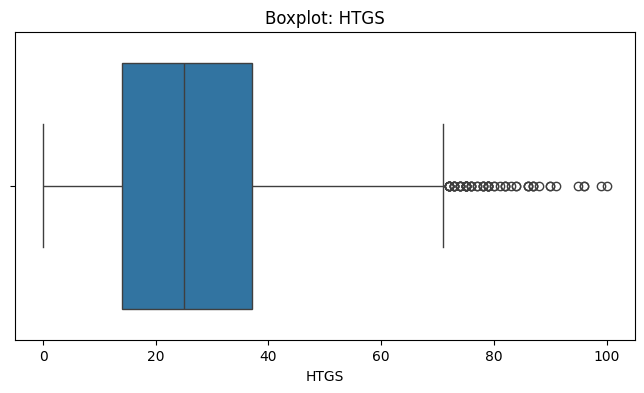

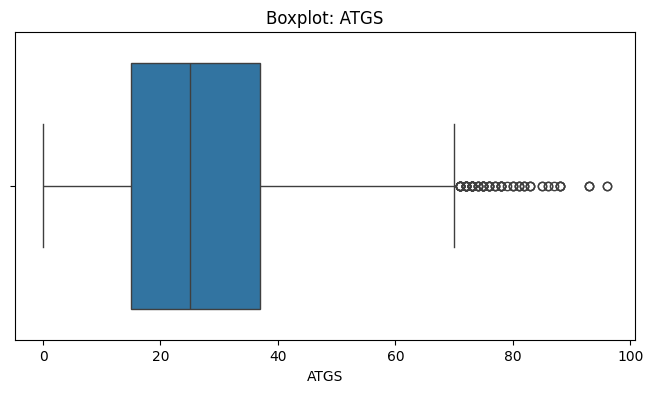

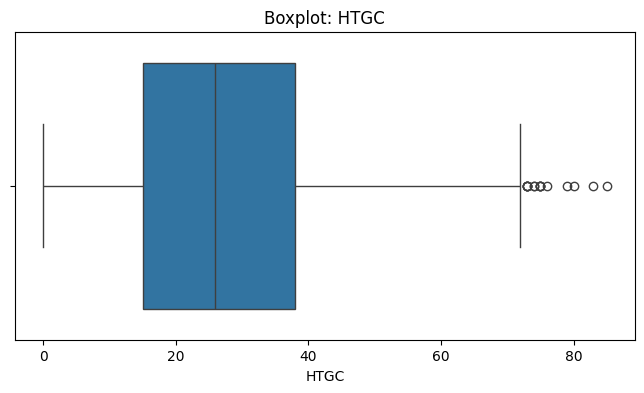

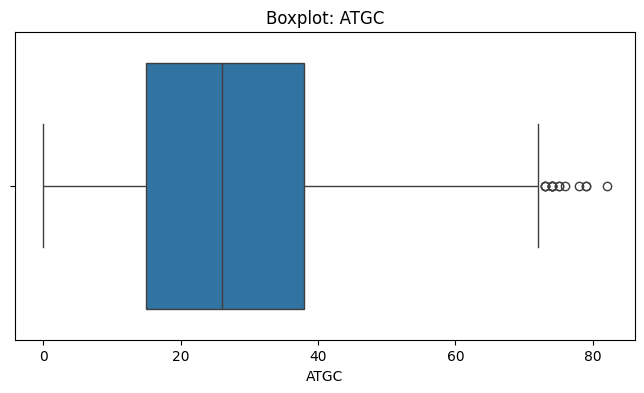

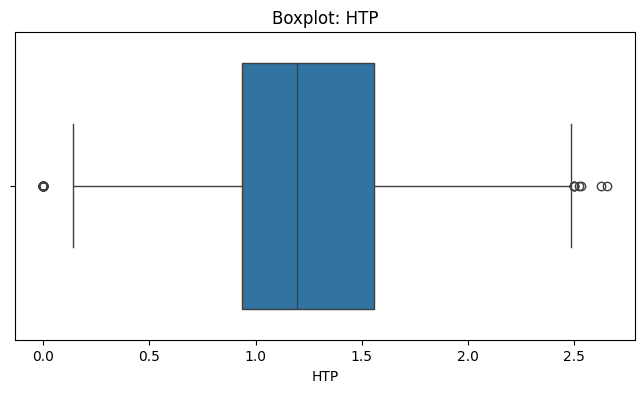

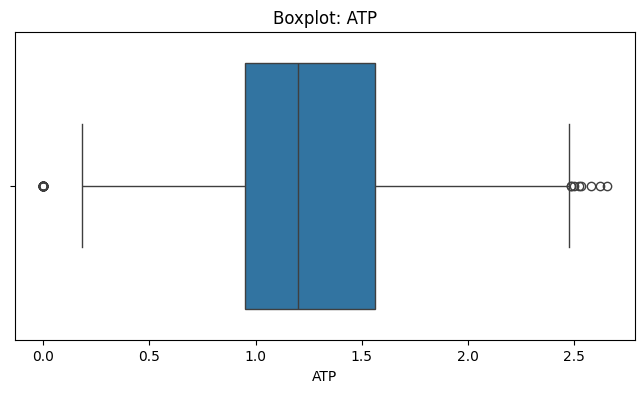

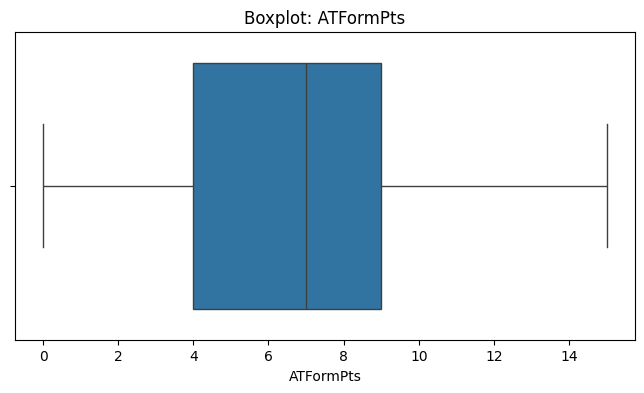

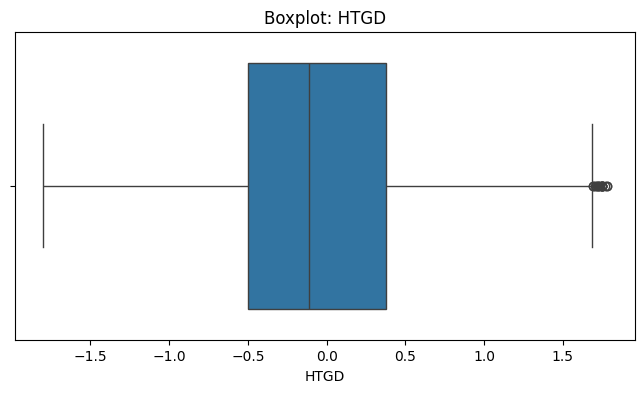

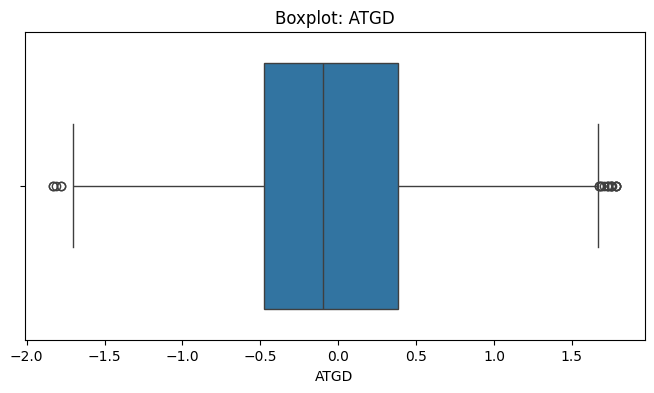

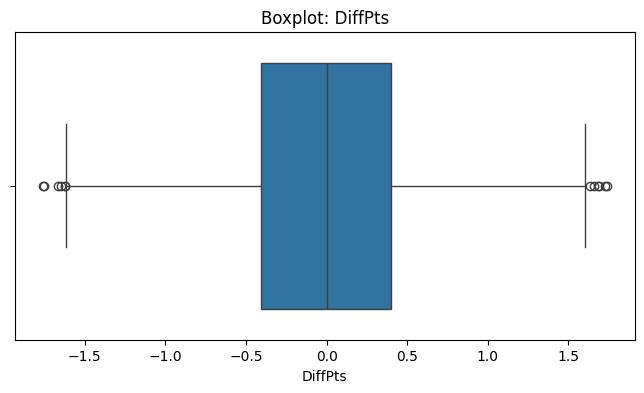

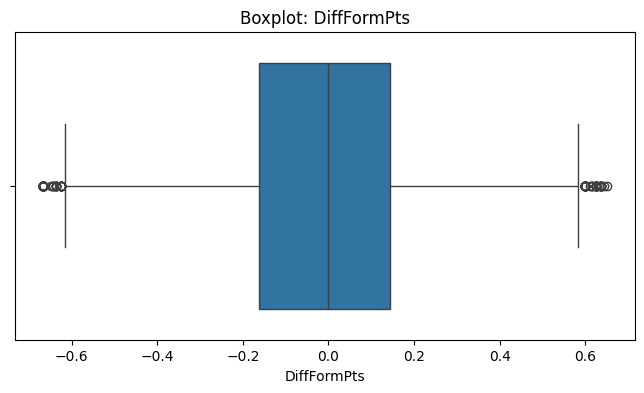

In [12]:
# -----------------------------
# 3. EDA: Numeric Boxplots
# -----------------------------
numeric_cols = df.select_dtypes(include=[np.number]).columns
for col in numeric_cols:
    plt.figure(figsize=(8, 4))
    sns.boxplot(x=df[col])
    plt.title(f'Boxplot: {col}')
    plt.show()


In [13]:

# -----------------------------
# 5. Feature Engineering
# -----------------------------
df['FTR_numeric'] = df['FTR'].map({'H': 1, 'NH': 0})
y = df['FTR_numeric']
X = df.drop(columns=['FTR', 'FTR_numeric'])
X = pd.get_dummies(X, drop_first=True)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)



Random Forest Accuracy: 0.6384228187919463
              precision    recall  f1-score   support

      NH (0)       0.64      0.74      0.69       639
       H (1)       0.63      0.53      0.57       553

    accuracy                           0.64      1192
   macro avg       0.64      0.63      0.63      1192
weighted avg       0.64      0.64      0.63      1192



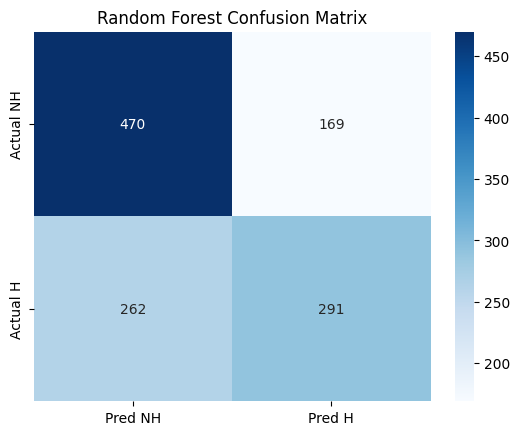

In [14]:
# -----------------------------
# 6. Random Forest Model
# -----------------------------
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf_model.fit(X_train, y_train)
y_pred = rf_model.predict(X_test)

print("\nRandom Forest Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred, target_names=['NH (0)', 'H (1)']))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Pred NH', 'Pred H'], yticklabels=['Actual NH', 'Actual H'])
plt.title("Random Forest Confusion Matrix")
plt.show()


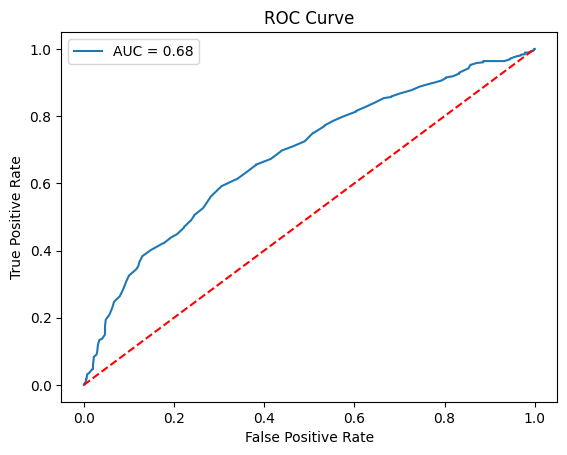


Top 10 RF Features:
         Feature  Importance
9       DiffPts    0.087811
8          ATGD    0.083635
7          HTGD    0.081712
4           HTP    0.077854
5           ATP    0.074692
10  DiffFormPts    0.069276
0          HTGS    0.064068
3          ATGC    0.061851
1          ATGS    0.061479
2          HTGC    0.059560


In [15]:

# ROC-AUC
y_proba = rf_model.predict_proba(X_test)[:,1]
auc = roc_auc_score(y_test, y_proba)
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.plot(fpr, tpr, label=f"AUC = {auc:.2f}")
plt.plot([0,1], [0,1], '--', color='red')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

# Feature Importance
importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': rf_model.feature_importances_})
print("\nTop 10 RF Features:\n", importance_df.sort_values('Importance', ascending=False).head(10))


In [16]:
# -----------------------------
# 7. Logistic Regression
# -----------------------------
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

log_model = LogisticRegression(random_state=42, max_iter=1000, n_jobs=-1)
log_model.fit(X_train_scaled, y_train)
y_pred_log = log_model.predict(X_test_scaled)

print("\nLogistic Regression Accuracy:", accuracy_score(y_test, y_pred_log))
print(classification_report(y_test, y_pred_log, target_names=['NH (0)', 'H (1)']))

# Feature Coefficients
coeff_df = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': log_model.coef_[0],
    'Abs_Coeff': np.abs(log_model.coef_[0])
})
print("\nTop 10 Logistic Regression Features:\n", coeff_df.sort_values('Abs_Coeff', ascending=False).head(10))



Logistic Regression Accuracy: 0.6552013422818792
              precision    recall  f1-score   support

      NH (0)       0.66      0.73      0.69       639
       H (1)       0.65      0.57      0.60       553

    accuracy                           0.66      1192
   macro avg       0.65      0.65      0.65      1192
weighted avg       0.65      0.66      0.65      1192


Top 10 Logistic Regression Features:
         Feature  Coefficient  Abs_Coeff
7          HTGD     0.288105   0.288105
8          ATGD    -0.276217   0.276217
13        HM1_W     0.270380   0.270380
0          HTGS     0.268763   0.268763
1          ATGS    -0.212671   0.212671
26        AM1_L     0.211500   0.211500
28        AM1_W    -0.068096   0.068096
10  DiffFormPts    -0.066919   0.066919
11        HM1_L     0.061975   0.061975
21        HM4_M    -0.060508   0.060508



===== XGBoost Regressor Performance =====
Mean Absolute Error (MAE): 0.434
Root Mean Squared Error (RMSE): 0.484
R-Squared (R²): 0.056


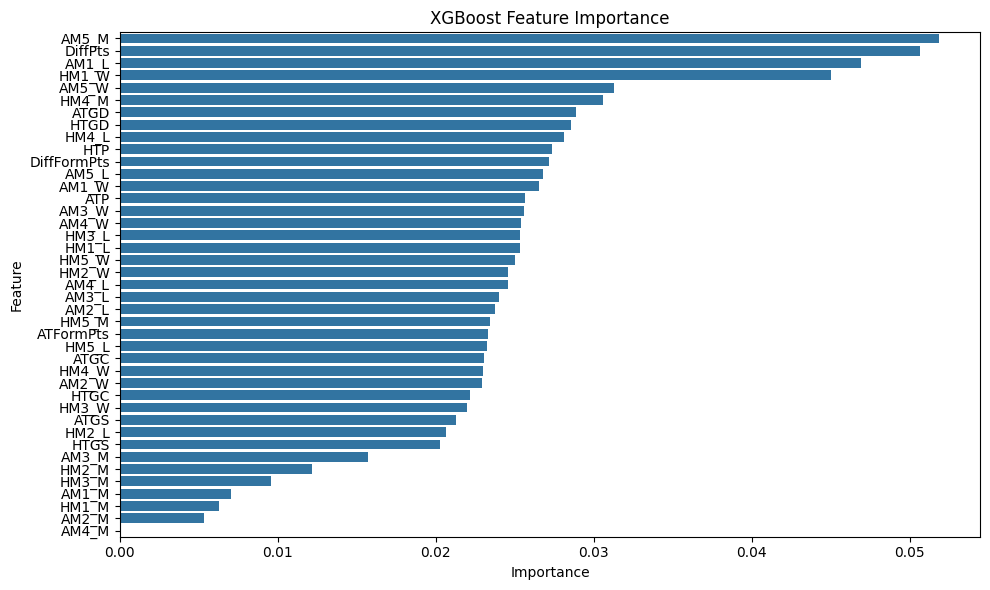

In [18]:
# ===================== XGBoost Regressor =====================
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

xgb_model = XGBRegressor(
    n_estimators=300,
    max_depth=6,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    objective='reg:squarederror'
)

xgb_model.fit(X_train, y_train)

y_pred_xgb = xgb_model.predict(X_test)

mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred_xgb))
r2_xgb = r2_score(y_test, y_pred_xgb)

print("\n===== XGBoost Regressor Performance =====")
print(f"Mean Absolute Error (MAE): {mae_xgb:.3f}")
print(f"Root Mean Squared Error (RMSE): {rmse_xgb:.3f}")
print(f"R-Squared (R²): {r2_xgb:.3f}")

# Feature Importance Plot
import matplotlib.pyplot as plt
import seaborn as sns

feature_importances = pd.DataFrame({
    'Feature': X.columns,
    'Importance': xgb_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importances)
plt.title("XGBoost Feature Importance")
plt.tight_layout()
plt.show()
